In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (7, 4)
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers, models




In [2]:
# Load dataset
df = pd.read_csv("ai4i2020.csv")
print(df.shape)
df.head()



(10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
display(df.info())
print("\nMissing values per column:")
display(df.isna().sum())
print("\nUnique values per column:")
display(df.nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

None


Missing values per column:


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


Unique values per column:


UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

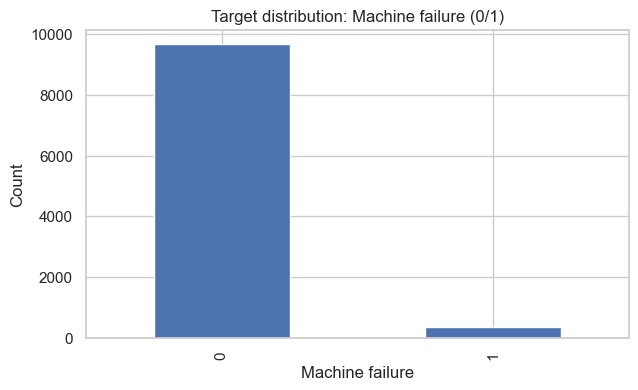

Failure type counts:


HDF    115
OSF     98
PWF     95
TWF     46
RNF     19
dtype: int64

In [4]:
# Binary target
ax = df["Machine failure"].value_counts().sort_index().plot(kind="bar")
plt.title("Target distribution: Machine failure (0/1)")
plt.xlabel("Machine failure"); plt.ylabel("Count"); plt.show()

fail_cols = ["TWF","HDF","PWF","OSF","RNF"]
print("Failure type counts:")
display(df[fail_cols].sum().sort_values(ascending=False))


In [5]:
num_cols = ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]",
            "Torque [Nm]","Tool wear [min]"]
display(df[num_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


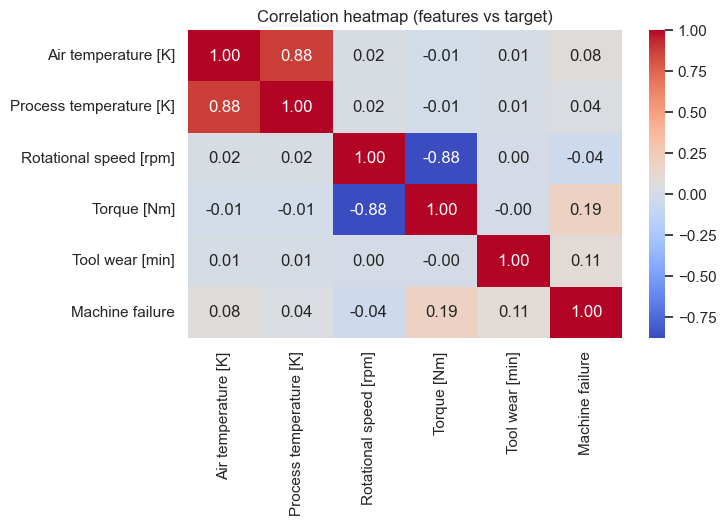

In [6]:
corr_cols = num_cols + ["Machine failure"]
corr = df[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap (features vs target)")
plt.show()


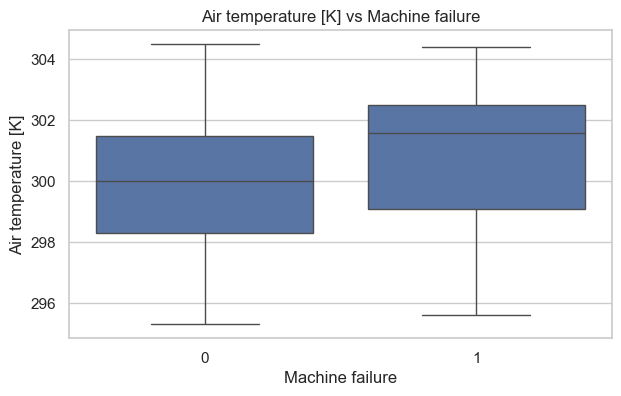

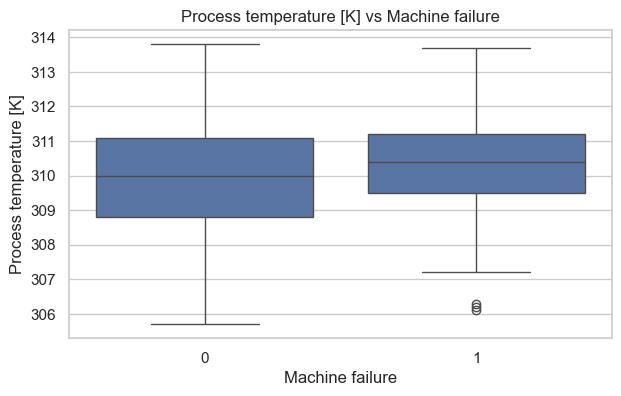

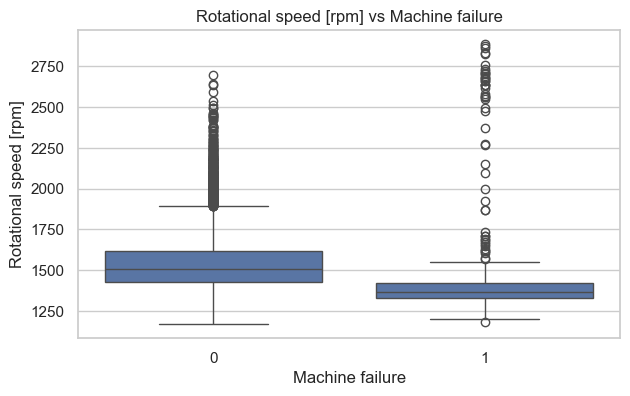

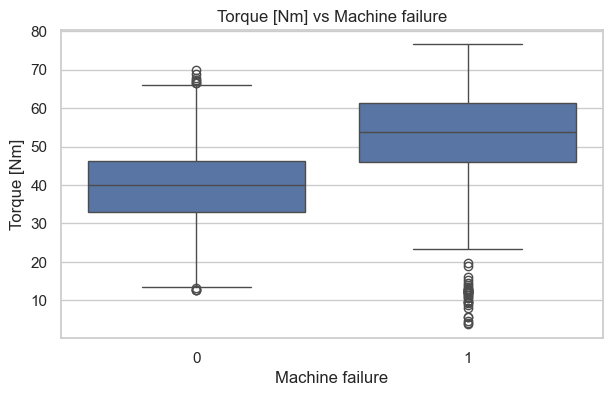

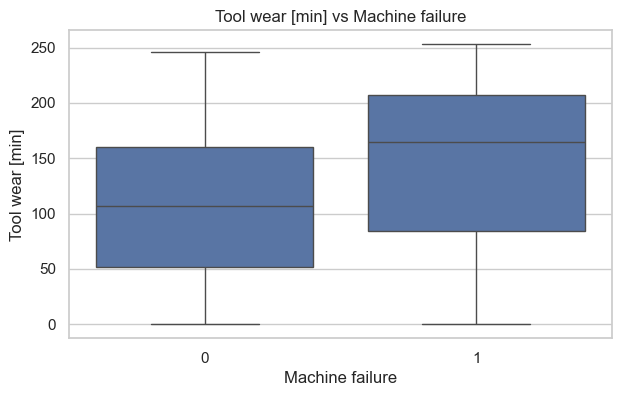

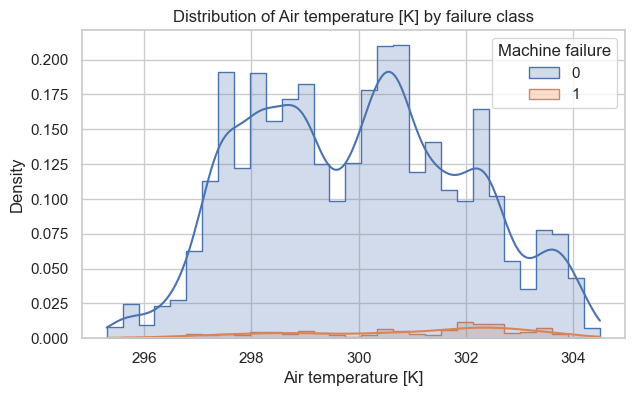

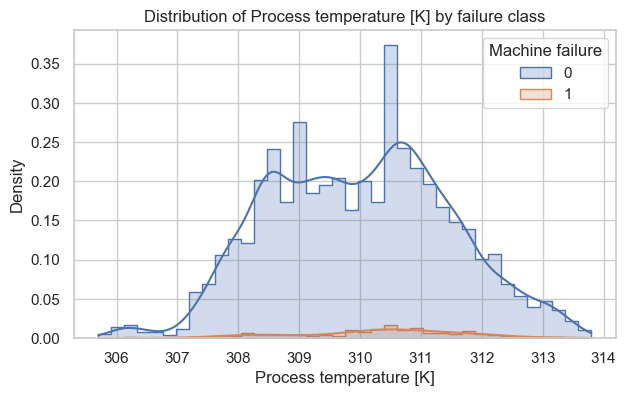

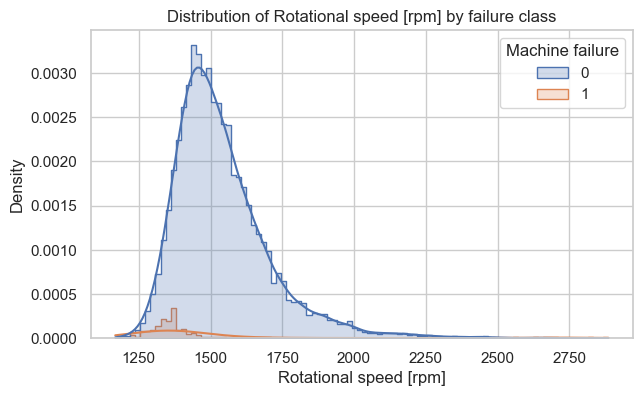

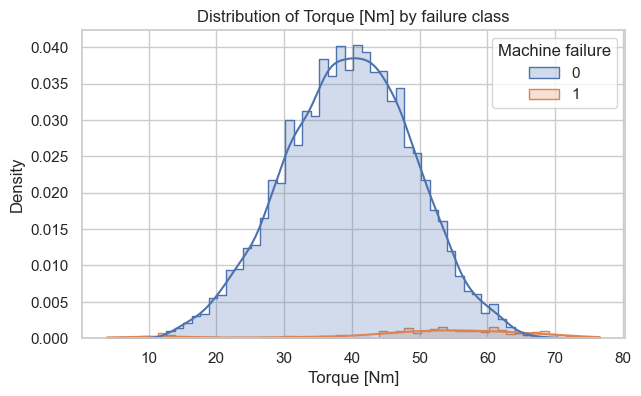

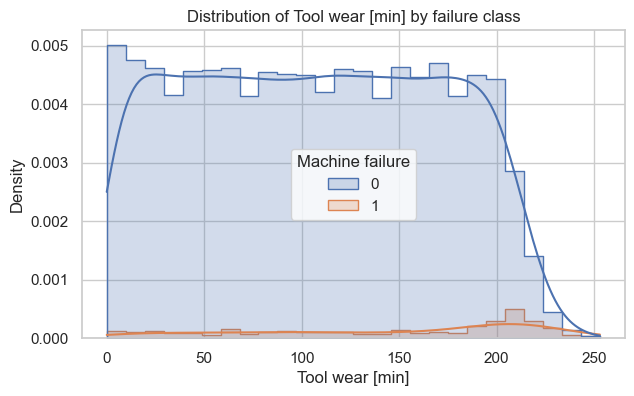

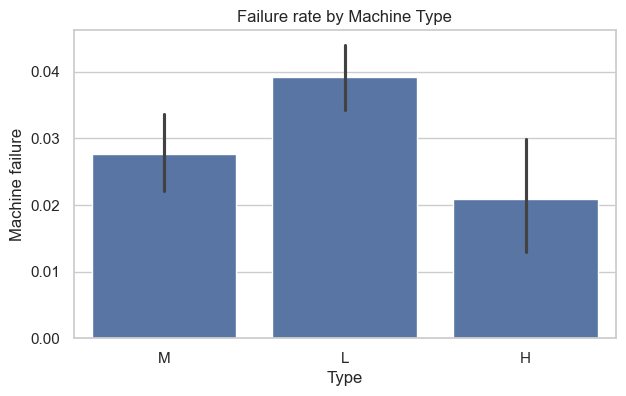

In [7]:
# Boxplots by failure
for c in num_cols:
    sns.boxplot(x="Machine failure", y=c, data=df)
    plt.title(f"{c} vs Machine failure")
    plt.show()

# Histograms by class
for c in num_cols:
    sns.histplot(data=df, x=c, hue="Machine failure", kde=True, stat="density", element="step")
    plt.title(f"Distribution of {c} by failure class")
    plt.show()

# Failure rate by machine Type
sns.barplot(x="Type", y="Machine failure", data=df)
plt.title("Failure rate by Machine Type")
plt.show()


In [8]:
# 1) Drop identifiers
work = df.drop(columns=["UDI","Product ID"], errors="ignore").copy()

# 2) Encode categorical (Type)
if work["Type"].dtype == "object":
    le_type = LabelEncoder()
    work["Type"] = le_type.fit_transform(work["Type"])
else:
    le_type = None  # already numeric

# 3) X/y
X = work.drop("Machine failure", axis=1)
y = work["Machine failure"]

# 4) Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 5) Scale (fit on train, apply to test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 6) Handle imbalance (train only)
sm = SMOTE(random_state=42)
X_train_resampled_scaled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

print("Shapes:")
print("  X_train_resampled_scaled:", X_train_resampled_scaled.shape)
print("  y_train_resampled:", y_train_resampled.shape)
print("  X_test_scaled:", X_test_scaled.shape)
print("  y_test:", y_test.shape)


Shapes:
  X_train_resampled_scaled: (15458, 11)
  y_train_resampled: (15458,)
  X_test_scaled: (2000, 11)
  y_test: (2000,)


=== Random Forest Metrics ===
Accuracy: 0.999
Precision: 1.0
Recall: 0.9705882352941176
F1: 0.9850746268656716
ROC-AUC: 0.9890162586773841

Classification Report:
               precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995      1932
           1     1.0000    0.9706    0.9851        68

    accuracy                         0.9990      2000
   macro avg     0.9995    0.9853    0.9923      2000
weighted avg     0.9990    0.9990    0.9990      2000



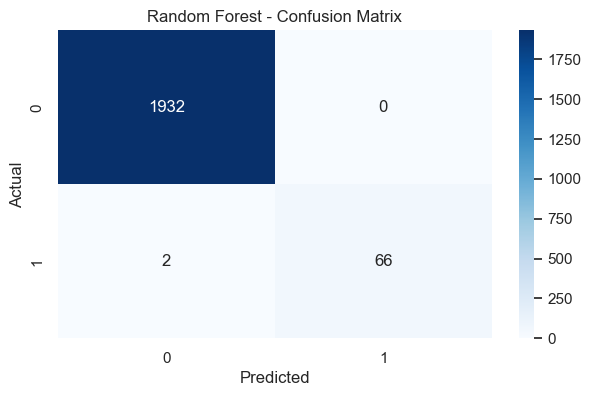

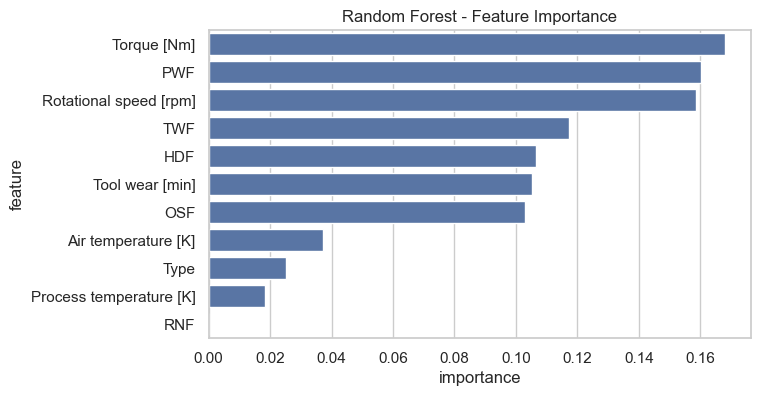

In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train_resampled_scaled, y_train_resampled)

# Predict
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:,1]

# Metrics
print("=== Random Forest Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# Feature Importance
imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
sns.barplot(data=imp, x="importance", y="feature")
plt.title("Random Forest - Feature Importance"); plt.show()


LSTM shapes: (15458, 1, 11) (15458,)  |  (2000, 1, 11) (2000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9706 - auc: 0.9882 - loss: 0.1477 - val_accuracy: 0.9990 - val_auc: 0.9766 - val_loss: 0.0272
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9871 - auc: 0.9938 - loss: 0.0546 - val_accuracy: 0.9990 - val_auc: 0.9783 - val_loss: 0.0223
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9871 - auc: 0.9954 - loss: 0.0508 - val_accuracy: 0.9990 - val_auc: 0.9835 - val_loss: 0.0244
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9871 - auc: 0.9972 - loss: 0.0457 - val_accuracy: 0.9990 - val_auc: 0.9859 - val_loss: 0.0264
Epoch 5/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9871 - auc: 0.9976 - loss: 0.0438 - val_accuracy: 0.9990 - val_auc: 0.9862 - val_loss: 0.0335
Epoch 6/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9871 - auc: 0.9982 - loss: 0.0410 - val_accuracy: 0.9990 - val_auc: 0.9884 - val_loss: 0.0276
Epoch 7/20
484/484 ━━━━━━━━━━━━━━━━━━━

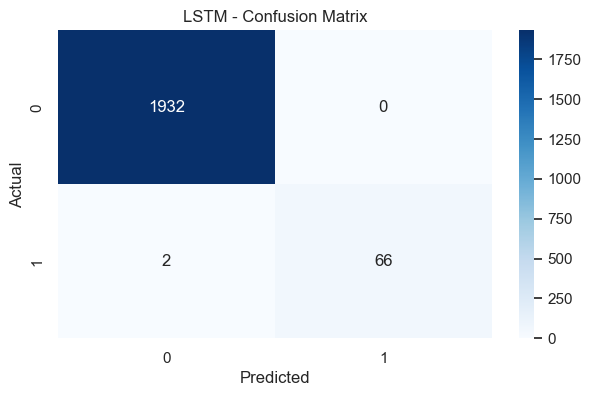

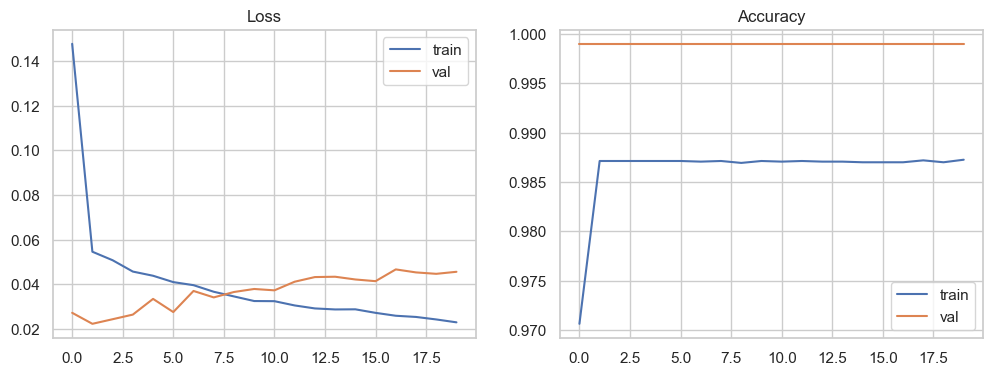

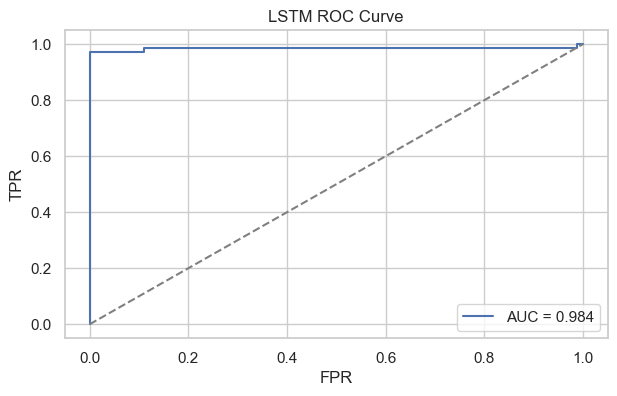

In [10]:
# --- Reshape for LSTM ---
X_train_lstm = np.expand_dims(X_train_resampled_scaled, axis=1)  # (N, 1, F)
X_test_lstm  = np.expand_dims(X_test_scaled, axis=1)             # (M, 1, F)

y_train_lstm = np.array(y_train_resampled)
y_test_lstm  = np.array(y_test)

print("LSTM shapes:", X_train_lstm.shape, y_train_lstm.shape, " | ", X_test_lstm.shape, y_test_lstm.shape)

# --- Class weights (optional, helps if imbalance persists after SMOTE) ---
# After SMOTE, classes are balanced; you can set class_weight=None.
class_weight_dict = None

# --- Build model ---
model = models.Sequential([
    layers.Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),  # (1, F)
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

model.summary()

# --- Train ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# --- Evaluate ---
y_proba_lstm = model.predict(X_test_lstm).ravel()
y_pred_lstm = (y_proba_lstm >= 0.5).astype(int)

print("=== LSTM Metrics ===")
print("Accuracy:", accuracy_score(y_test_lstm, y_pred_lstm))
print("Precision:", precision_score(y_test_lstm, y_pred_lstm))
print("Recall:", recall_score(y_test_lstm, y_pred_lstm))
print("F1:", f1_score(y_test_lstm, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_test_lstm, y_proba_lstm))
print("\nClassification Report:\n", classification_report(y_test_lstm, y_pred_lstm, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# Training Curves
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="val")
ax[0].set_title("Loss"); ax[0].legend()

ax[1].plot(history.history["accuracy"], label="train")
ax[1].plot(history.history["val_accuracy"], label="val")
ax[1].set_title("Accuracy"); ax[1].legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_lstm, y_proba_lstm)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_lstm, y_proba_lstm):.3f}")
plt.plot([0,1],[0,1],"--", c="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("LSTM ROC Curve"); plt.legend(); plt.show()


In [11]:
results = pd.DataFrame([
    {"Model":"Random Forest",
     "Accuracy": accuracy_score(y_test, y_pred_rf),
     "Precision": precision_score(y_test, y_pred_rf),
     "Recall": recall_score(y_test, y_pred_rf),
     "F1": f1_score(y_test, y_pred_rf),
     "ROC-AUC": roc_auc_score(y_test, y_proba_rf)},
    {"Model":"LSTM",
     "Accuracy": accuracy_score(y_test_lstm, y_pred_lstm),
     "Precision": precision_score(y_test_lstm, y_pred_lstm),
     "Recall": recall_score(y_test_lstm, y_pred_lstm),
     "F1": f1_score(y_test_lstm, y_pred_lstm),
     "ROC-AUC": roc_auc_score(y_test_lstm, y_proba_lstm)},
])
results


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Random Forest,0.999,1.0,0.970588,0.985075,0.989016
1,LSTM,0.999,1.0,0.970588,0.985075,0.983825
